## Random Forest - pair distribution function (PDF) - structure type 7cat unbalanced

In [1]:
import numpy as np
import pandas as pd
import h5py
from debyecalculator import DebyeCalculator
from ase.io import read
import glob
import os
import sys
import random
import tiktoken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

random.seed(42)
np.random.seed(42)

/home/vicky/anaconda3/envs/debyecalculator_env/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def process_xyz_files():
    # Initialise DebyeCalculator object
    calc = DebyeCalculator()
    print(calc)
    
    # Load XYZ files
    XYZ_files = sorted(glob.glob("../xyz_files/*.xyz"))
    random.shuffle(XYZ_files)

    # Calculate Pair Distribution Function for all XYZ files
    scattering_files = []
    structure_types = []
    num_atoms = []

    for iter, xyz_file in enumerate(XYZ_files):
        # Extract structure type
        structure_type = os.path.basename(xyz_file).split('_')[0]

        # Calculate the scattering pattern
        scatt_x, scatt_Int = calc.gr(structure_source=xyz_file)

        # Normalise the scattering files
        scatt_Int /= max(scatt_Int)
        scattering_files.append(scatt_Int)

        # Increment the count for this structure type
        structure_types.append(structure_type)

        atoms = read(xyz_file)
        num_atoms.append(len(atoms))

    return scattering_files, structure_types, num_atoms

In [3]:
# Simulate scattering data
scattering_files, structure_types, num_atoms = process_xyz_files()

/tmp/ipykernel_5746/1612413307.py:3: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator()


DebyeCalculator{'qmin': 1.0, 'qmax': 30.0, 'qdamp': 0.04, 'qstep': 0.05, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


In [4]:
len(scattering_files[0])

2000

In [5]:
np.set_printoptions(threshold=sys.maxsize)

In [6]:
scattering_files[0]

array([ 0.00000000e+00, -1.24081259e-03, -2.43981788e-03, -3.55886901e-03,
       -4.56686504e-03, -5.44242794e-03, -6.17583841e-03, -6.76981779e-03,
       -7.23938225e-03, -7.61045050e-03, -7.91762862e-03, -8.20107665e-03,
       -8.50310456e-03, -8.86432454e-03, -9.32015758e-03, -9.89775546e-03,
       -1.06134415e-02, -1.14714708e-02, -1.24634868e-02, -1.35693504e-02,
       -1.47587219e-02, -1.59940217e-02, -1.72333848e-02, -1.84345916e-02,
       -1.95586290e-02, -2.05732044e-02, -2.14555021e-02, -2.21943278e-02,
       -2.27909349e-02, -2.32591350e-02, -2.36239322e-02, -2.39193980e-02,
       -2.41856966e-02, -2.44655330e-02, -2.48004626e-02, -2.52271071e-02,
       -2.57741194e-02, -2.64594071e-02, -2.72887163e-02, -2.82550789e-02,
       -2.93392893e-02, -3.05116437e-02, -3.17345411e-02, -3.29658240e-02,
       -3.41622792e-02, -3.52836587e-02, -3.62959877e-02, -3.71749178e-02,
       -3.79074812e-02, -3.84935588e-02, -3.89457569e-02, -3.92884202e-02,
       -3.95554863e-02, -

In [7]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0])))
num_tokens

19524

In [8]:
len(scattering_files[0].round(3)[::15])

134

In [9]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0].round(3)[::15])))
num_tokens

551

In [10]:
scattering_patterns = []

In [11]:
for i in np.arange(len(scattering_files)):
    pattern = scattering_files[i].round(3)[::15]
    scattering_patterns.append(pattern)

In [12]:
len(scattering_patterns[0])

134

### prepare clasification dataset for structure type

In [13]:
scattering_patterns = np.array(scattering_patterns)

In [14]:
le = LabelEncoder()
encoded_structure_types = le.fit_transform(structure_types)

In [15]:
class_indices = {i: np.where(encoded_structure_types == i)[0] for i in np.unique(encoded_structure_types)}

In [16]:
class_indices

{0: array([   5,   41,   50,   57,   68,   69,   77,   83,   86,   92,  104,
         105,  115,  118,  120,  124,  128,  137,  141,  146,  155,  168,
         179,  188,  193,  203,  222,  235,  253,  265,  268,  270,  275,
         292,  317,  366,  378,  382,  390,  394,  395,  403,  413,  417,
         463,  488,  502,  516,  526,  540,  548,  552,  581,  582,  601,
         611,  612,  619,  635,  639,  643,  653,  656,  667,  677,  682,
         697,  700,  711,  713,  717,  722,  724,  730,  732,  753,  755,
         764,  776,  811,  816,  831,  837,  843,  849,  855,  868,  885,
         898,  911,  917,  926,  934,  964,  971,  977,  989,  997, 1004,
        1006, 1010, 1011, 1019, 1023, 1034, 1038, 1039, 1042, 1046, 1058,
        1062, 1069, 1097, 1098, 1109, 1120, 1127, 1146, 1154, 1157, 1159,
        1164, 1180, 1183, 1184, 1188, 1209, 1213, 1221, 1234, 1238, 1243,
        1257, 1264, 1299, 1310, 1314, 1327, 1342, 1367, 1373, 1389, 1395,
        1410, 1419, 1429, 1448, 145

In [17]:
for cat in class_indices:
    print(cat)

0
1
2
3
4
5
6


In [18]:
for indices in class_indices.values():
    print(len(indices))

209
342
95
1007
38
76
190


In [70]:
indices = np.arange(len(scattering_patterns))
indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [20]:
MAX_TEST_DATA = 2000
train_size = 200

In [21]:
train_indices, test_indices = train_test_split(
    indices, 
    train_size=train_size,
    test_size=min(len(indices)-train_size, MAX_TEST_DATA),
    random_state=42,
    stratify=encoded_structure_types,
)

In [22]:
len(train_indices)

200

In [23]:
len(test_indices)

1757

In [24]:
X_train, y_train = scattering_patterns[train_indices], encoded_structure_types[train_indices]
X_test, y_test = scattering_patterns[test_indices], encoded_structure_types[test_indices]

In [25]:
print(np.unique(y_train, return_counts=True))
for n in np.unique(y_train):
    print(f'{n}: {np.unique(y_train, return_counts=True)[1][n]/len(y_train)*100}')

(array([0, 1, 2, 3, 4, 5, 6]), array([ 21,  35,  10, 103,   4,   8,  19]))
0: 10.5
1: 17.5
2: 5.0
3: 51.5
4: 2.0
5: 4.0
6: 9.5


In [26]:
print(np.unique(y_test, return_counts=True))
for n in np.unique(y_test):
    print(f'{n}: {np.unique(y_test, return_counts=True)[1][n]/len(y_test)*100}')

(array([0, 1, 2, 3, 4, 5, 6]), array([188, 307,  85, 904,  34,  68, 171]))
0: 10.700056915196358
1: 17.47296528173022
2: 4.837791690381332
3: 51.4513375071144
4: 1.935116676152533
5: 3.870233352305066
6: 9.732498577120092


In [27]:
X_train[0]

array([ 0.   , -0.008, -0.016, -0.024, -0.031, -0.039, -0.047, -0.053,
       -0.06 , -0.068, -0.073, -0.077, -0.085, -0.091, -0.091, -0.097,
       -0.107, -0.073,  0.635,  0.708, -0.07 , -0.119, -0.111, -0.11 ,
       -0.116, -0.089,  0.112, -0.015, -0.108, -0.104, -0.098, -0.016,
        0.403,  0.064, -0.08 , -0.082, -0.05 ,  0.092, -0.021, -0.063,
       -0.049,  0.096,  0.077, -0.037, -0.038, -0.032, -0.028, -0.024,
       -0.019, -0.016, -0.012, -0.008,  0.009,  0.009,  0.   ,  0.002,
        0.003,  0.005,  0.006,  0.007,  0.007,  0.008,  0.008,  0.008,
        0.008,  0.008,  0.007,  0.006,  0.005,  0.005,  0.003,  0.002,
        0.002,  0.001, -0.   , -0.001, -0.002, -0.003, -0.003, -0.004,
       -0.004, -0.005, -0.005, -0.005, -0.005, -0.005, -0.004, -0.004,
       -0.004, -0.003, -0.003, -0.002, -0.002, -0.001, -0.001, -0.   ,
        0.001,  0.001,  0.001,  0.002,  0.002,  0.003,  0.003,  0.003,
        0.003,  0.003,  0.003,  0.003,  0.003,  0.003,  0.002,  0.002,
      

### train and evaluate classifier

In [28]:
clf = RandomForestClassifier(
    n_estimators=500, 
    random_state=42, 
    verbose=True
)

In [29]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s


RandomForestClassifier(n_estimators=500, random_state=42, verbose=True)

In [30]:
y_pred = clf.predict(X_test)
y_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


array([3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 1, 3, 3, 1, 6, 3, 1, 2, 1, 3, 4,
       0, 3, 3, 6, 6, 3, 1, 3, 3, 1, 3, 0, 3, 3, 2, 1, 3, 3, 3, 6, 3, 1,
       2, 1, 1, 3, 6, 3, 0, 0, 3, 3, 6, 3, 3, 3, 3, 3, 0, 3, 6, 5, 6, 6,
       0, 3, 3, 3, 3, 0, 6, 3, 1, 0, 3, 1, 1, 3, 3, 0, 3, 0, 1, 1, 3, 3,
       3, 1, 6, 4, 3, 3, 3, 3, 0, 5, 3, 3, 1, 3, 1, 0, 3, 1, 3, 2, 0, 3,
       0, 6, 1, 3, 6, 3, 0, 3, 3, 3, 3, 1, 1, 6, 0, 1, 3, 3, 1, 1, 6, 1,
       6, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 6, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3, 0, 0, 6, 3, 1, 6, 3, 1, 3,
       3, 3, 1, 0, 6, 3, 3, 1, 3, 2, 3, 3, 1, 3, 6, 6, 1, 3, 3, 3, 3, 1,
       1, 0, 3, 3, 3, 3, 3, 0, 6, 3, 6, 3, 0, 2, 0, 3, 6, 3, 0, 3, 3, 1,
       1, 3, 1, 1, 3, 3, 3, 2, 3, 3, 0, 3, 1, 3, 3, 0, 3, 3, 3, 1, 6, 1,
       3, 1, 0, 3, 3, 1, 3, 3, 5, 3, 3, 0, 1, 3, 0, 6, 3, 1, 0, 1, 1, 3,
       1, 3, 1, 1, 6, 3, 3, 1, 4, 3, 1, 6, 3, 3, 3, 3, 0, 3, 3, 0, 3, 2,
       0, 3, 3, 3, 3, 3, 2, 6, 3, 1, 3, 0, 3, 6, 0,

In [31]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5, 6])

In [32]:
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

In [33]:
acc, f1_macro, f1_micro, f1_weighted, kappa

(0.8366533864541833,
 0.6209309616315203,
 0.8366533864541833,
 0.8199232207205036,
 0.7511289684165225)

In [40]:
def prepare_dataset_classification(scattering_patterns, structure_types, max_test_data=2000, train_size=200, random_state=42):
    """
    Prepares the dataset for classification by splitting it into training and test sets.

    Parameters:
    scattering_patterns (list or numpy.ndarray): The scattering patterns for each structure.
    structure_types (list of str): The structure type for each scattering pattern.
    num_data_per_class (int): Number of data in the less represented class.
    train_size (int): The number of samples used for training.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set labels.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set labels.
        - le (LabelEncoder): The label encoder used to encode the structure types.
    """
    # Convert scattering_files to a NumPy array
    scattering_patterns = np.array(scattering_patterns)
    
    # Encode the structure types into integers
    le = LabelEncoder()
    encoded_structure_types = le.fit_transform(structure_types)
    
    # Create a dictionary to store indices of each class
    class_indices = {i: np.where(encoded_structure_types == i)[0] for i in np.unique(encoded_structure_types)}
    
    # Split the samples into train and test sets
    indices = np.arange(len(num_atoms))
    train_indices, test_indices = train_test_split(
        indices, 
        train_size=train_size,
        test_size=min(len(indices)-train_size, max_test_data),
        random_state=random_state,
        stratify=encoded_structure_types,
    )
    
    print(f"train: {len(train_indices)}")
    print(f"test: {len(test_indices)}")
    
    # Create the training, validation, and test sets
    X_train, y_train = scattering_patterns[train_indices], encoded_structure_types[train_indices]
    X_test, y_test = scattering_patterns[test_indices], encoded_structure_types[test_indices]
    
    return X_train, y_train, X_test, y_test, le

In [41]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, le, random_state=42):
    # Create a classifier
    clf = RandomForestClassifier(
        n_estimators=500, 
        random_state=42, 
        verbose=True
    )
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predict the test set results
    y_pred = clf.predict(X_test)
    
    # Convert the predictions back to the original classes
    #y_pred = le.inverse_transform(y_pred)
    
    # Convert the test labels back to the original classes
    #y_test = le.inverse_transform(y_test)
    
    y_test = np.array(y_test)
    
    # Calculate classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [42]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 600

In [43]:
train_size = 600
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [45]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train,  
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 600
test: 1357
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8909358879882093
F1 macro for structure type classification: 0.7323489552815293
F1 micro for structure type classification: 0.8909358879882093
F1 weighted for structure type classification: 0.8835627301772506
Kappa for structure type classification: 0.8392104148636456
-------------Iteration 2/10
train: 600
test: 1357
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8916728076639646
F1 macro for structure type classification: 0.7312137834275783
F1 micro for structure type classification: 0.8916728076639646
F1 weighted for structure type classification: 0.8857689606296585
Kappa for structure type classification: 0.8402202069426222
-------------Iteration 3/10
train: 600
test: 1357
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8769344141488578
F1 macro for structure type classification: 0.7145084477321333
F1 micro for structure type classification: 0.8769344141488578
F1 weighted for structure type classification: 0.8693175165975668
Kappa for structure type classification: 0.8183902519163191
-------------Iteration 4/10
train: 600
test: 1357
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9027266028002948
F1 macro for structure type classification: 0.7751481589319722
F1 micro for structure type classification: 0.9027266028002948
F1 weighted for structure type classification: 0.8953918757753125
Kappa for structure type classification: 0.8567881019730372
-------------Iteration 5/10
train: 600
test: 1357
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8997789240972734
F1 macro for structure type classification: 0.7597902853273374
F1 micro for structure type classification: 0.8997789240972734
F1 weighted for structure type classification: 0.8922287695770917
Kappa for structure type classification: 0.851241761155941
-------------Iteration 6/10
train: 600
test: 1357
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.899042004421518
F1 macro for structure type classification: 0.7353856611847723
F1 micro for structure type classification: 0.899042004421518
F1 weighted for structure type classification: 0.8877674227085719
Kappa for structure type classification: 0.8496451181914938
-------------Iteration 7/10
train: 600
test: 1357
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8835666912306559
F1 macro for structure type classification: 0.7432579232076965
F1 micro for structure type classification: 0.8835666912306559
F1 weighted for structure type classification: 0.8754920725502896
Kappa for structure type classification: 0.8266738560511686
-------------Iteration 8/10
train: 600
test: 1357
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8872512896094326
F1 macro for structure type classification: 0.7253612027664751
F1 micro for structure type classification: 0.8872512896094326
F1 weighted for structure type classification: 0.8768652699747098
Kappa for structure type classification: 0.832269640482588
-------------Iteration 9/10
train: 600
test: 1357
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.8997789240972734
F1 macro for structure type classification: 0.7656048652410916
F1 micro for structure type classification: 0.8997789240972734
F1 weighted for structure type classification: 0.8965876476056578
Kappa for structure type classification: 0.8525309977202682
-------------Iteration 10/10
train: 600
test: 1357
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.3s


Accuracy for structure type classification: 0.8784082535003684
F1 macro for structure type classification: 0.718571399388945
F1 micro for structure type classification: 0.8784082535003684
F1 weighted for structure type classification: 0.870711612302038
Kappa for structure type classification: 0.8196223028537548


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [46]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 600
mean accuracy for structure type classification: 0.8910095799557848 +/- 0.008845799126194223
mean F1 macro for structure type classification: 0.7401190682489531 +/- 0.019425387100565645
mean F1 micro for structure type classification: 0.8910095799557848 +/- 0.008845799126194223
mean F1 weighted for structure type classification: 0.8833693877898148 +/- 0.009407014967833935
mean Kappa for structure type classification: 0.8386592652150838 +/- 0.013268550533971366


In [47]:
compiled_res_600 = pd.DataFrame(metrics_dict())
compiled_res_600.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 2, 3, 3, 5, 3, 1, 3, 4, 3, 3, 3, 3, 2, 3, ...","[1, 2, 3, 3, 1, 3, 1, 1, 4, 3, 3, 3, 3, 1, 3, ...",0.890936,0.732349,0.890936,0.883563,0.83921
1,600,"[3, 1, 5, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...","[3, 1, 1, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...",0.891673,0.731214,0.891673,0.885769,0.84022
2,600,"[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 4, 1, 3, 3, ...","[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 1, 1, 3, 3, ...",0.876934,0.714508,0.876934,0.869318,0.81839


### training size = 1000

In [48]:
train_size = 1000
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [49]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train,  
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1000
test: 957
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9299895506792059
F1 macro for structure type classification: 0.8063833044284214
F1 micro for structure type classification: 0.9299895506792059
F1 weighted for structure type classification: 0.9254142152310778
Kappa for structure type classification: 0.8970151267414705
-------------Iteration 2/10
train: 1000
test: 957
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9164054336468129
F1 macro for structure type classification: 0.7775279467406749
F1 micro for structure type classification: 0.9164054336468129
F1 weighted for structure type classification: 0.9077959347755326
Kappa for structure type classification: 0.876770538243626
-------------Iteration 3/10
train: 1000
test: 957
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9059561128526645
F1 macro for structure type classification: 0.7749046522827332
F1 micro for structure type classification: 0.9059561128526645
F1 weighted for structure type classification: 0.8990328032927148
Kappa for structure type classification: 0.8613411895390114
-------------Iteration 4/10
train: 1000
test: 957
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9122257053291536
F1 macro for structure type classification: 0.7920909874559989
F1 micro for structure type classification: 0.9122257053291536
F1 weighted for structure type classification: 0.9069114044906117
Kappa for structure type classification: 0.8710530157085363
-------------Iteration 5/10
train: 1000
test: 957
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9247648902821317
F1 macro for structure type classification: 0.8108045356096177
F1 micro for structure type classification: 0.9247648902821317
F1 weighted for structure type classification: 0.9186103249924505
Kappa for structure type classification: 0.888598229962588
-------------Iteration 6/10
train: 1000
test: 957
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9205851619644723
F1 macro for structure type classification: 0.7787781024945827
F1 micro for structure type classification: 0.9205851619644723
F1 weighted for structure type classification: 0.9165436692603729
Kappa for structure type classification: 0.8831783356623139
-------------Iteration 7/10
train: 1000
test: 957
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9216300940438872
F1 macro for structure type classification: 0.8136767380848695
F1 micro for structure type classification: 0.9216300940438872
F1 weighted for structure type classification: 0.9176052976594847
Kappa for structure type classification: 0.8847413806946831
-------------Iteration 8/10
train: 1000
test: 957
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9143155694879833
F1 macro for structure type classification: 0.7904915283499638
F1 micro for structure type classification: 0.9143155694879833
F1 weighted for structure type classification: 0.9076909088913941
Kappa for structure type classification: 0.873591731932126
-------------Iteration 9/10
train: 1000
test: 957
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9237199582027168
F1 macro for structure type classification: 0.8164718599305241
F1 micro for structure type classification: 0.9237199582027168
F1 weighted for structure type classification: 0.9195705257853937
Kappa for structure type classification: 0.8876368531692356
-------------Iteration 10/10
train: 1000
test: 957
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.6s


Accuracy for structure type classification: 0.928944618599791
F1 macro for structure type classification: 0.8178163595227758
F1 micro for structure type classification: 0.928944618599791
F1 weighted for structure type classification: 0.9234743095532694
Kappa for structure type classification: 0.8950392175521731


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [50]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1000
mean accuracy for structure type classification: 0.919853709508882 +/- 0.007225159420297834
mean F1 macro for structure type classification: 0.7978946014900161 +/- 0.016208200511396462
mean F1 micro for structure type classification: 0.919853709508882 +/- 0.007225159420297834
mean F1 weighted for structure type classification: 0.9142649393932303 +/- 0.008022838775081507
mean Kappa for structure type classification: 0.8818965619205763 +/- 0.010603074003857382


In [51]:
compiled_res_1000 = pd.DataFrame(metrics_dict())
compiled_res_1000.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1000,"[4, 3, 0, 3, 3, 1, 3, 3, 3, 2, 1, 3, 1, 3, 3, ...","[1, 3, 0, 3, 3, 1, 3, 3, 3, 2, 1, 3, 5, 3, 3, ...",0.929990,0.806383,0.929990,0.925414,0.897015
1,1000,"[5, 3, 3, 6, 6, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 3, 6, 6, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, ...",0.916405,0.777528,0.916405,0.907796,0.876771
2,1000,"[3, 1, 1, 1, 3, 3, 5, 3, 3, 3, 6, 3, 3, 3, 3, ...","[3, 1, 1, 1, 3, 1, 2, 3, 3, 3, 6, 3, 3, 3, 3, ...",0.905956,0.774905,0.905956,0.899033,0.861341


### training size = 1400

In [52]:
train_size = 1400
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [53]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train,  
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1400
test: 557
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9353680430879713
F1 macro for structure type classification: 0.8331619010452594
F1 micro for structure type classification: 0.9353680430879713
F1 weighted for structure type classification: 0.9327243289358773
Kappa for structure type classification: 0.904617389773911
-------------Iteration 2/10
train: 1400
test: 557
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9389587073608617
F1 macro for structure type classification: 0.8314472475235213
F1 micro for structure type classification: 0.9389587073608617
F1 weighted for structure type classification: 0.9312070565737546
Kappa for structure type classification: 0.9096822807870967
-------------Iteration 3/10
train: 1400
test: 557
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9084380610412927
F1 macro for structure type classification: 0.7676989738055621
F1 micro for structure type classification: 0.9084380610412927
F1 weighted for structure type classification: 0.9019704370039872
Kappa for structure type classification: 0.8652949739903169
-------------Iteration 4/10
train: 1400
test: 557
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.933572710951526
F1 macro for structure type classification: 0.8280250551334681
F1 micro for structure type classification: 0.933572710951526
F1 weighted for structure type classification: 0.9265823437442018
Kappa for structure type classification: 0.9017889479804044
-------------Iteration 5/10
train: 1400
test: 557
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.940754039497307
F1 macro for structure type classification: 0.8232673231516346
F1 micro for structure type classification: 0.940754039497307
F1 weighted for structure type classification: 0.9344627576258274
Kappa for structure type classification: 0.9121371312756631
-------------Iteration 6/10
train: 1400
test: 557
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.940754039497307
F1 macro for structure type classification: 0.83909269488972
F1 micro for structure type classification: 0.940754039497307
F1 weighted for structure type classification: 0.9364280312237313
Kappa for structure type classification: 0.9125368177124721
-------------Iteration 7/10
train: 1400
test: 557
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9371633752244165
F1 macro for structure type classification: 0.8446492358945425
F1 micro for structure type classification: 0.9371633752244165
F1 weighted for structure type classification: 0.9316664526024099
Kappa for structure type classification: 0.9071073923360621
-------------Iteration 8/10
train: 1400
test: 557
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9461400359066428
F1 macro for structure type classification: 0.8687791185630152
F1 micro for structure type classification: 0.9461400359066428
F1 weighted for structure type classification: 0.9423961583207703
Kappa for structure type classification: 0.9203238542083881
-------------Iteration 9/10
train: 1400
test: 557
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9281867145421903
F1 macro for structure type classification: 0.8470935432029376
F1 micro for structure type classification: 0.9281867145421903
F1 weighted for structure type classification: 0.9264374635249787
Kappa for structure type classification: 0.8947612052392672
-------------Iteration 10/10
train: 1400
test: 557
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9515260323159784
F1 macro for structure type classification: 0.873853157292358
F1 micro for structure type classification: 0.9515260323159784
F1 weighted for structure type classification: 0.9488663715663689
Kappa for structure type classification: 0.9283164201585342


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [54]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1400
mean accuracy for structure type classification: 0.9360861759425495 +/- 0.011072993856451895
mean F1 macro for structure type classification: 0.8357068250502019 +/- 0.02762869288374587
mean F1 micro for structure type classification: 0.9360861759425495 +/- 0.011072993856451895
mean F1 weighted for structure type classification: 0.9312741401121908 +/- 0.011731541408290701
mean Kappa for structure type classification: 0.9056566413462116 +/- 0.016124672252104105


In [55]:
compiled_res_1400 = pd.DataFrame(metrics_dict())
compiled_res_1400.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1400,"[1, 2, 6, 3, 3, 3, 3, 0, 3, 1, 1, 0, 0, 3, 3, ...","[1, 2, 6, 3, 3, 3, 3, 0, 3, 1, 1, 0, 0, 3, 3, ...",0.935368,0.833162,0.935368,0.932724,0.904617
1,1400,"[3, 3, 0, 3, 3, 6, 6, 6, 3, 6, 6, 3, 1, 0, 3, ...","[3, 3, 0, 3, 3, 6, 6, 6, 3, 6, 6, 3, 1, 0, 3, ...",0.938959,0.831447,0.938959,0.931207,0.909682
2,1400,"[3, 3, 1, 1, 1, 3, 0, 3, 3, 6, 3, 3, 3, 3, 3, ...","[3, 3, 1, 1, 1, 3, 0, 3, 3, 6, 3, 3, 3, 3, 3, ...",0.908438,0.767699,0.908438,0.901970,0.865295


### training size = 1800

In [56]:
train_size = 1800
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [57]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train,  
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1800
test: 157
random_state = 42


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9235668789808917
F1 macro for structure type classification: 0.8086149567039291
F1 micro for structure type classification: 0.9235668789808917
F1 weighted for structure type classification: 0.9209335041425218
Kappa for structure type classification: 0.887111270896998
-------------Iteration 2/10
train: 1800
test: 157
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9363057324840764
F1 macro for structure type classification: 0.8396978994611092
F1 micro for structure type classification: 0.9363057324840764
F1 weighted for structure type classification: 0.9308787200099139
Kappa for structure type classification: 0.9058470764617691
-------------Iteration 3/10
train: 1800
test: 157
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9363057324840764
F1 macro for structure type classification: 0.8402168292340944
F1 micro for structure type classification: 0.9363057324840764
F1 weighted for structure type classification: 0.9322310443836477
Kappa for structure type classification: 0.9060836274451157
-------------Iteration 4/10
train: 1800
test: 157
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9299363057324841
F1 macro for structure type classification: 0.773325172095664
F1 micro for structure type classification: 0.9299363057324841
F1 weighted for structure type classification: 0.91328973139561
Kappa for structure type classification: 0.8959638554216868
-------------Iteration 5/10
train: 1800
test: 157
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9426751592356688
F1 macro for structure type classification: 0.8224803252611929
F1 micro for structure type classification: 0.9426751592356688
F1 weighted for structure type classification: 0.9350673580780635
Kappa for structure type classification: 0.9151657060518732
-------------Iteration 6/10
train: 1800
test: 157
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9426751592356688
F1 macro for structure type classification: 0.8474489795918368
F1 micro for structure type classification: 0.9426751592356688
F1 weighted for structure type classification: 0.9384895359417651
Kappa for structure type classification: 0.9153588115490595
-------------Iteration 7/10
train: 1800
test: 157
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9490445859872612
F1 macro for structure type classification: 0.8192682512658118
F1 micro for structure type classification: 0.9490445859872612
F1 weighted for structure type classification: 0.9319548679159491
Kappa for structure type classification: 0.9247904191616767
-------------Iteration 8/10
train: 1800
test: 157
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9554140127388535
F1 macro for structure type classification: 0.8458049886621316
F1 micro for structure type classification: 0.9554140127388535
F1 weighted for structure type classification: 0.9477302598321706
Kappa for structure type classification: 0.9342781963879918
-------------Iteration 9/10
train: 1800
test: 157
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


Accuracy for structure type classification: 0.9299363057324841
F1 macro for structure type classification: 0.8630146398181914
F1 micro for structure type classification: 0.9299363057324841
F1 weighted for structure type classification: 0.9267508854280806
Kappa for structure type classification: 0.8974039089882968
-------------Iteration 10/10
train: 1800
test: 157
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    2.2s


Accuracy for structure type classification: 0.9490445859872612
F1 macro for structure type classification: 0.8152644108490854
F1 micro for structure type classification: 0.9490445859872612
F1 weighted for structure type classification: 0.9393198021948713
Kappa for structure type classification: 0.9244556718392879


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s


In [58]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1800
mean accuracy for structure type classification: 0.9394904458598725 +/- 0.009554140127388533
mean F1 macro for structure type classification: 0.8275136452943046 +/- 0.02416413452933735
mean F1 micro for structure type classification: 0.9394904458598725 +/- 0.009554140127388533
mean F1 weighted for structure type classification: 0.9316645709322595 +/- 0.009234855641063628
mean Kappa for structure type classification: 0.9106458544203756 +/- 0.014073156715246064


In [59]:
compiled_res_1800 = pd.DataFrame(metrics_dict())
compiled_res_1800.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1800,"[1, 3, 5, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 6, ...","[1, 3, 2, 6, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 6, ...",0.923567,0.808615,0.923567,0.920934,0.887111
1,1800,"[1, 3, 3, 3, 3, 2, 0, 1, 3, 6, 2, 3, 3, 3, 5, ...","[1, 3, 3, 3, 3, 1, 0, 1, 3, 2, 2, 3, 3, 3, 5, ...",0.936306,0.839698,0.936306,0.930879,0.905847
2,1800,"[3, 0, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 6, 0, 2, ...","[3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 6, 0, 1, ...",0.936306,0.840217,0.936306,0.932231,0.906084


In [60]:
compiled_res = pd.concat([
    compiled_res_600,
    compiled_res_1000,
    compiled_res_1400,
    compiled_res_1800
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

40


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 2, 3, 3, 5, 3, 1, 3, 4, 3, 3, 3, 3, 2, 3, ...","[1, 2, 3, 3, 1, 3, 1, 1, 4, 3, 3, 3, 3, 1, 3, ...",0.890936,0.732349,0.890936,0.883563,0.839210
1,600,"[3, 1, 5, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...","[3, 1, 1, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...",0.891673,0.731214,0.891673,0.885769,0.840220
2,600,"[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 4, 1, 3, 3, ...","[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 1, 1, 3, 3, ...",0.876934,0.714508,0.876934,0.869318,0.818390
3,600,"[1, 1, 3, 3, 1, 0, 3, 1, 3, 0, 1, 3, 2, 1, 3, ...","[1, 1, 3, 3, 1, 6, 3, 1, 3, 0, 1, 3, 2, 1, 3, ...",0.902727,0.775148,0.902727,0.895392,0.856788
4,600,"[3, 6, 3, 3, 3, 2, 3, 5, 0, 3, 3, 4, 2, 3, 3, ...","[3, 6, 3, 3, 3, 2, 3, 5, 0, 3, 3, 1, 2, 3, 3, ...",0.899779,0.759790,0.899779,0.892229,0.851242


In [61]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [62]:
compiled_res.to_csv("RF_results_structure_type_7cat_unbalanced.csv", sep=",", index=False)

In [63]:
df = pd.read_csv("RF_results_structure_type_7cat_unbalanced.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   40 non-null     int64  
 1   y_true       40 non-null     object 
 2   y_pred       40 non-null     object 
 3   accuracy     40 non-null     float64
 4   f1_macro     40 non-null     float64
 5   f1_micro     40 non-null     float64
 6   f1_weighted  40 non-null     float64
 7   kappa        40 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.6+ KB


In [64]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[1, 2, 3, 3, 5, 3, 1, 3, 4, 3, 3, 3, 3, 2, 3, ...","[1, 2, 3, 3, 1, 3, 1, 1, 4, 3, 3, 3, 3, 1, 3, ...",0.890936,0.732349,0.890936,0.883563,0.83921
1,600,"[3, 1, 5, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...","[3, 1, 1, 3, 3, 6, 3, 1, 1, 3, 3, 3, 3, 6, 5, ...",0.891673,0.731214,0.891673,0.885769,0.84022
2,600,"[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 4, 1, 3, 3, ...","[1, 3, 1, 0, 6, 1, 2, 3, 3, 3, 1, 1, 1, 3, 3, ...",0.876934,0.714508,0.876934,0.869318,0.81839


In [65]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
600         0.891010  0.002949  0.740119  0.006475  0.891010  0.002949   
1000        0.919854  0.002408  0.797895  0.005403  0.919854  0.002408   
1400        0.936086  0.003691  0.835707  0.009210  0.936086  0.003691   
1800        0.939490  0.003185  0.827514  0.008055  0.939490  0.003185   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
600           0.883369  0.003136  0.838659  0.004423  
1000          0.914265  0.002674  0.881897  0.003534  
1400          0.931274  0.003911  0.905657  0.005375  
1800          0.931665  0.003078  0.910646  0.004691

In [66]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.97058824 0.         0.         0.         0.         0.
  0.02941176]
 [0.         0.98148148 0.0037037  0.0037037  0.         0.01111111
  0.        ]
 [0.         0.2125     0.75       0.         0.         0.0375
  0.        ]
 [0.         0.00987654 0.         0.99012346 0.         0.
  0.        ]
 [0.         0.         0.03333333 0.         0.93333333 0.
  0.03333333]
 [0.         0.38333333 0.4        0.01666667 0.         0.2
  0.        ]
 [0.02       0.         0.02666667 0.         0.         0.
  0.95333333]]
accuracy: 0.9394904458598726


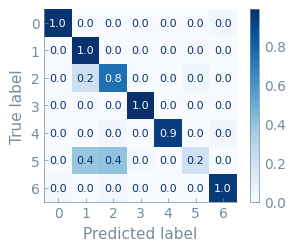

In [67]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

plt.rcParams.update({'font.size': 8})
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1, 2, 3, 4, 5, 6])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".1f")
#plt.savefig('classif_struct_type_confusionMatrix_7cat_uunbalanced_30ep_size1800_RF.pdf', bbox_inches='tight')

[[0.97058824 0.         0.         0.         0.         0.
  0.02941176]
 [0.         0.98148148 0.0037037  0.0037037  0.         0.01111111
  0.        ]
 [0.         0.2125     0.75       0.         0.         0.0375
  0.        ]
 [0.         0.00987654 0.         0.99012346 0.         0.
  0.        ]
 [0.         0.         0.03333333 0.         0.93333333 0.
  0.03333333]
 [0.         0.38333333 0.4        0.01666667 0.         0.2
  0.        ]
 [0.02       0.         0.02666667 0.         0.         0.
  0.95333333]]
accuracy: 0.9394904458598726


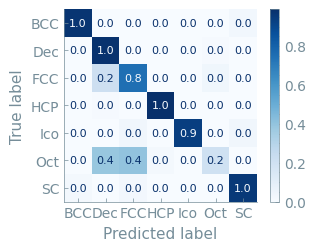

In [68]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

plt.rcParams.update({'font.size': 8})
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = ['BCC', 'Dec', 'FCC', 'HCP', 'Ico', 'Oct', 'SC'])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".1f")
#plt.savefig('classif_struct_type_confusionMatrix_7cat_unbalanced_30ep_size1800_RF.pdf', bbox_inches='tight')